## **Prepocessing**

In [ ]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_test.csv')
holdout_data = pd.read_csv('/content/drive/MyDrive/SPH 6004/Assignment 2/Version 2/merged_holdout.csv')

In [ ]:
los_icu_stats = train_data['los_icu'].describe()

los_icu_stats

count    64985.000000
mean         5.209080
std          6.481275
min          1.000000
25%          1.890000
50%          3.040000
75%          5.820000
max        101.730000
Name: los_icu, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Dropping non-numeric columns for simplicity and focusing on numeric features for CNN input
# Normally, we would carefully select features or encode categorical ones differently
numeric_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Using the numeric columns for both train and test data
train_numeric = train_data[numeric_columns].drop(columns=['los_icu', 'icu_death'])
test_numeric = test_data[numeric_columns].drop(columns=['los_icu', 'icu_death'])
holdout_numeric = holdout_data[numeric_columns].drop(columns=['los_icu', 'icu_death'])

# print(train_numeric.columns)

# Normalizing the data
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train_numeric)
test_normalized = scaler.transform(test_numeric)
holdout_normalized = scaler.transform(holdout_numeric)

# Reshaping the data to fit a CNN. Since we're treating each row as a "channel",
# and assuming each feature as a 1D spatial dimension, we add an extra dimension to mimic images
train_reshaped = np.expand_dims(train_normalized, axis=2)
test_reshaped = np.expand_dims(test_normalized, axis=2)
holdout_reshaped = np.expand_dims(holdout_normalized, axis=2)

train_reshaped.shape, test_reshaped.shape, holdout_reshaped.shape

((64985, 62, 1), (18781, 62, 1), (9838, 62, 1))

## **Prediction of length of stay (los_icu)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

# Defining the CNN model
model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(62, 1)),
    MaxPooling1D(pool_size=2),
    # Additional convolutional layer
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Flatten the output of the convolutional layers
    Flatten(),
    # Dense layer for prediction
    Dense(50, activation='relu'),
    # Output layer
    Dense(1)
])

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model summary to inspect the architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 60, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 28, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 14, 128)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1792)              0         
                                                                 
 dense_4 (Dense)             (None, 50)               

In [ ]:
train_targets = train_data['los_icu']
test_targets = test_data['los_icu']
holdout_targets = holdout_data['los_icu']

In [ ]:
print(model.layers[0].input_shape)

(None, 62, 1)


In [ ]:
history = model.fit(train_reshaped, train_targets, epochs=5, validation_data = (holdout_reshaped, holdout_targets))

Epoch 1/5
2031/2031 [==============================] - 22s 11ms/step - loss: 10.3495 - mae: 1.5148 - val_loss: 23.7643 - val_mae: 2.2851
Epoch 2/5
2031/2031 [==============================] - 23s 11ms/step - loss: 9.3795 - mae: 1.4525 - val_loss: 18.3479 - val_mae: 2.1112
Epoch 3/5
2031/2031 [==============================] - 20s 10ms/step - loss: 8.2969 - mae: 1.3768 - val_loss: 23.2907 - val_mae: 2.0276
Epoch 4/5
2031/2031 [==============================] - 22s 11ms/step - loss: 7.5625 - mae: 1.3214 - val_loss: 21.9834 - val_mae: 2.0780
Epoch 5/5
2031/2031 [==============================] - 20s 10ms/step - loss: 6.8009 - mae: 1.2748 - val_loss: 21.4125 - val_mae: 2.0015


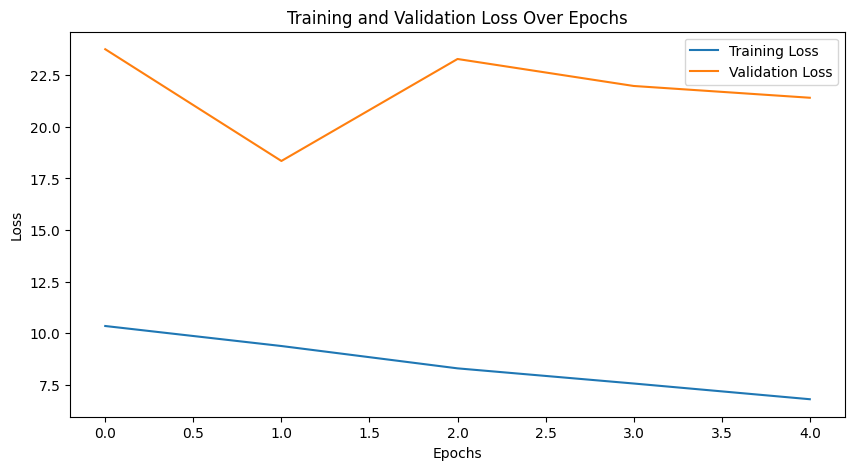

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_reshaped, test_targets)

587/587 [==============================] - 2s 4ms/step - loss: 37.6647 - mae: 2.3614


[37.664676666259766, 2.3613998889923096]

In [ ]:
test_predict = model.predict(test_reshaped)
test_predict = np.round(test_predict, 2)

587/587 [==============================] - 3s 5ms/step


In [ ]:
test_predict

array([[2.33],
       [4.14],
       [4.25],
       ...,
       [3.46],
       [1.32],
       [1.74]], dtype=float32)

In [ ]:
test_targets.values

array([2.87, 3.32, 3.32, ..., 5.12, 1.2 , 1.2 ])

## **Prediction of time-to-event (icu_death)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_targets_death = train_data['icu_death']

In [ ]:
history = model.fit(train_reshaped, train_targets_death, epochs=10, batch_size=32, validation_data = (holdout,holdout_data['los_icu']))

Epoch 1/10
1625/1625 [==============================] - 13s 7ms/step - loss: 0.0364 - accuracy: 0.9868 - val_loss: 0.0049 - val_accuracy: 0.9998
Epoch 2/10
1625/1625 [==============================] - 13s 8ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0059 - val_accuracy: 0.9991
Epoch 3/10
1625/1625 [==============================] - 13s 8ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0169 - val_accuracy: 0.9924
Epoch 4/10
1625/1625 [==============================] - 12s 8ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 8.9034e-04 - val_accuracy: 0.9995
Epoch 5/10
1625/1625 [==============================] - 13s 8ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 6/10
1625/1625 [==============================] - 13s 8ms/step - loss: 3.5384e-05 - accuracy: 1.0000 - val_loss: 6.1431e-04 - val_accuracy: 0.9998
Epoch 7/10
1625/1625 [==============================] - 13s 8ms/step - loss: 9.1299e-06 - accuracy: 1.0000 - val_loss:

In [ ]:
test_targets_death = test_data['icu_death']
test_loss, test_accuracy = model.evaluate(test_reshaped, test_targets_death)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

587/587 [==============================] - 2s 4ms/step - loss: 6.2128e-04 - accuracy: 0.9999
Test Loss: 0.0006212809821590781, Test Accuracy: 0.9999467730522156


In [ ]:
predictions = model.predict(test_reshaped)

587/587 [==============================] - 3s 5ms/step


In [ ]:
binary_predictions = (predictions > 0.5).astype(int)